# Capstone Project - The Battle of Neighborhoods

## Vietnamese Restaurant

### Introduction

New York City's demographics show that it is a large and ethnically diverse metropolis. It is the largest city in the United States with a long history of international immigration. New York City was home to nearly 8.5 million people in 2014, accounting for over 40% of the population of New York State and a slightly lower percentage of the New York metropolitan area, home to approximately 23.6 million. Over the last decade the city has been growing faster than the region. The New York region continues to be by far the leading metropolitan gateway for legal immigrants admitted into the United States.

Throughout its history, New York City has been a major point of entry for immigrants; the term "melting pot" was coined to describe densely populated immigrant neighborhoods on the Lower East Side. As many as 800 languages are spoken in New York, making it the most linguistically diverse city in the world. English remains the most widely spoken language, although there are areas in the outer boroughs in which up to 25% of people speak English as an alternate language, and/or have limited or no English language fluency. English is least spoken in neighborhoods such as Flushing, Sunset Park, and Corona. (Source: Wiki)

With that cultural diversity, of course the cuisine will also be very rich. There are many eateries opened here serving many different subjects. In this project we will list and visualize all Vietnamese restaurants.

### Data

We will use data:

- New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude:
    - Data source : https://cocl.us/new_york_dataset
    - We will use this dataset to explore the neighborhoods of new york.
- Vietnamese restaurant in NewYork city:
    - Use Foursquare API get info.
- GeoSpace data:
    - Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm
    - Visualize choropleth map 

## Analysis

Import the require library

In [7]:
!pip install geocoder

     |████████████████████████████████| 102kB 4.6MB/s ta 0:00:01


In [9]:
!pip install folium

     |████████████████████████████████| 92kB 12.2MB/s eta 0:00:01


In [10]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

Now we define a function to get the geocodes 

In [11]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category

In [25]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'VUC3Y3PE0DSEZEB1KY3GMNMX2YGMFBXHGJMNTQZJAVASJ32J' # your Foursquare ID
    CLIENT_SECRET = 'MXFQKHN0P1BAFF0RDGMAOBBRDT0GQMBWE5MTHK5O11OZUVNQ' # your Foursquare Secret
    VERSION = '20200306' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Venue detail

In [38]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'VUC3Y3PE0DSEZEB1KY3GMNMX2YGMFBXHGJMNTQZJAVASJ32J' # your Foursquare ID
    CLIENT_SECRET = 'MXFQKHN0P1BAFF0RDGMAOBBRDT0GQMBWE5MTHK5O11OZUVNQ' # your Foursquare Secret
    VERSION = '20200306' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Get New York data

In [14]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [15]:
new_york_data=get_new_york_data()

In [16]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [17]:
new_york_data.shape

(306, 4)

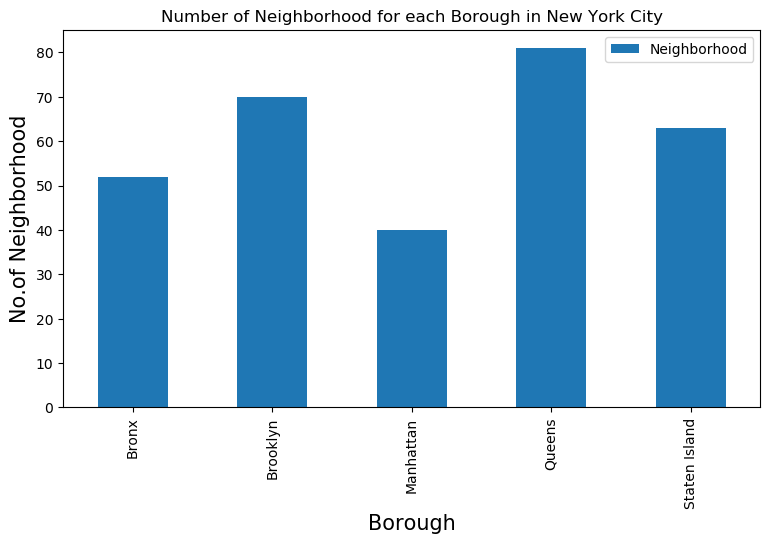

In [18]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Queens has a highest number of neighborhood

### Collect Vietnamese restaurant for each neigheborhood

In [26]:
# prepare neighborhood list that contains vietnamese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
vietnam_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    vietnam_restaurants=venues[venues['Category']=='Vietnamese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Vietnamese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(vietnam_restaurants)))
    for restaurant_detail in vietnam_restaurants.values.tolist():
        id, name , category=restaurant_detail
        vietnam_rest_ny = vietnam_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Vietnamese Restaurants in Wakefield, Bronx:0
( 2 / 306 ) Vietnamese Restaurants in Co-op City, Bronx:0
( 3 / 306 ) Vietnamese Restaurants in Eastchester, Bronx:0
( 4 / 306 ) Vietnamese Restaurants in Fieldston, Bronx:0
( 5 / 306 ) Vietnamese Restaurants in Riverdale, Bronx:0
( 6 / 306 ) Vietnamese Restaurants in Kingsbridge, Bronx:0
( 7 / 306 ) Vietnamese Restaurants in Marble Hill, Manhattan:0
( 8 / 306 ) Vietnamese Restaurants in Woodlawn, Bronx:0
( 9 / 306 ) Vietnamese Restaurants in Norwood, Bronx:0
( 10 / 306 ) Vietnamese Restaurants in Williamsbridge, Bronx:0
( 11 / 306 ) Vietnamese Restaurants in Baychester, Bronx:0
( 12 / 306 ) Vietnamese Restaurants in Pelham Parkway, Bronx:0
( 13 / 306 ) Vietnamese Restaurants in City Island, Bronx:0
( 14 / 306 ) Vietnamese Restaurants in Bedford Park, Bronx:0
( 15 / 306 ) Vietnamese Restaurants in University Heights, Bronx:0
( 16 / 306 ) Vietnamese Restaurants in Morris Heights, Bronx:0
( 17 / 306 ) Vietnamese Restaurants in Ford

In [28]:
vietnam_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Fordham,4aee2a4bf964a520a2d221e3,Cơm Tấm Ninh Kiều
1,Brooklyn,Bay Ridge,4af861e3f964a520bc0c22e3,Pho Hoai Bay Ridge
2,Brooklyn,Bensonhurst,5a5aaf7cc8b2fb7e920360f0,Em Vietnamese Restaurant
3,Brooklyn,Bensonhurst,55b7b8ba498e29e52cfc5658,Pho 18 Ave
4,Brooklyn,Sunset Park,49e4cedbf964a5204f631fe3,Ba Xuyên


In [29]:
vietnam_rest_ny.shape

(60, 4)

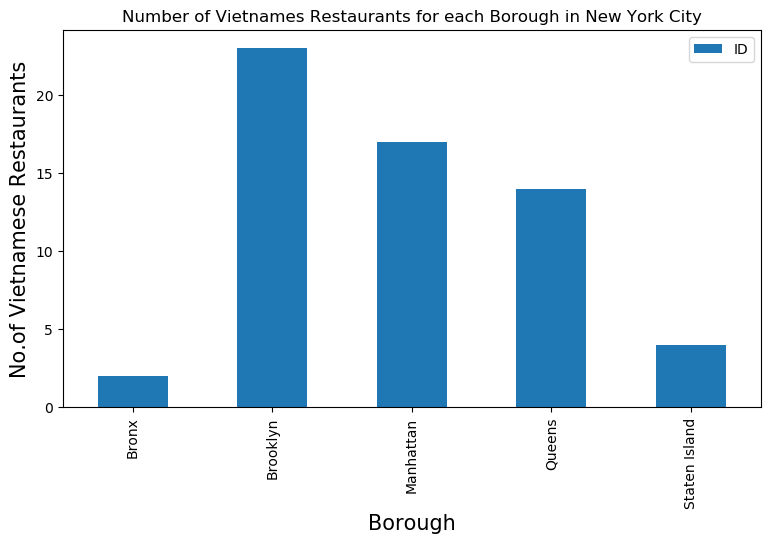

In [31]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Vietnames Restaurants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Vietnamese Restaurants', fontsize=15)
#giving a bar plot
vietnam_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Brooklyn has the highest number of Vietnamese Restaurants

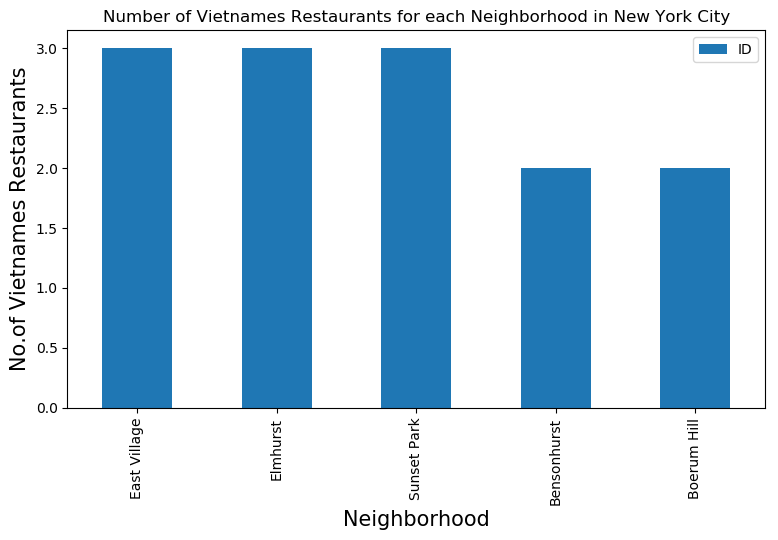

In [32]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Vietnames Restaurants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Vietnames Restaurants', fontsize=15)
#giving a bar plot
vietnam_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [34]:
vietnam_rest_ny[vietnam_rest_ny['Neighborhood']=='East Village']

,Borough,Neighborhood,ID,Name
27,Manhattan,East Village,4eee5e0693add02fcd39aa10,Xe Máy Sandwich Shop
28,Manhattan,East Village,58498a94f68d8d67be8e893c,Hanoi House
29,Manhattan,East Village,5c91430281635b002cd6b0e9,Van Da


In [35]:
vietnam_rest_ny[vietnam_rest_ny['Neighborhood']=='Elmhurst']

,Borough,Neighborhood,ID,Name
36,Queens,Elmhurst,4e0f605462e1d5a30d0ab7ff,JoJu
37,Queens,Elmhurst,4af78566f964a520af0922e3,Pho Bac
38,Queens,Elmhurst,4b4d2b63f964a52032cd26e3,Thai Son


In [36]:
vietnam_rest_ny[vietnam_rest_ny['Neighborhood']=='Sunset Park']

,Borough,Neighborhood,ID,Name
4,Brooklyn,Sunset Park,49e4cedbf964a5204f631fe3,Ba Xuyên
5,Brooklyn,Sunset Park,4aaea05bf964a520aa6220e3,Thanh Da
6,Brooklyn,Sunset Park,50dbb09be4b0e320417d97cf,Pho Viet


Ranking restaurants

In [40]:
# prepare neighborhood list that contains Vietnames Restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
vietnam_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in vietnam_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(vietnam_rest_ny),')','processed')
    vietnam_rest_stats_ny = vietnam_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID               Name  Likes  Rating  Tips
0  4aee2a4bf964a520a2d221e3  Cơm Tấm Ninh Kiều     52     7.8    34
( 1 / 60 ) processed
                         ID                Name  Likes  Rating  Tips
0  4af861e3f964a520bc0c22e3  Pho Hoai Bay Ridge     36     7.3    27
( 2 / 60 ) processed
                         ID                      Name  Likes  Rating  Tips
0  5a5aaf7cc8b2fb7e920360f0  Em Vietnamese Restaurant     18     7.7    10
( 3 / 60 ) processed
                         ID        Name  Likes  Rating  Tips
0  55b7b8ba498e29e52cfc5658  Pho 18 Ave      8     5.6     3
( 4 / 60 ) processed
                         ID      Name  Likes  Rating  Tips
0  49e4cedbf964a5204f631fe3  Ba Xuyên    154     9.0    74
( 5 / 60 ) processed
                         ID      Name  Likes  Rating  Tips
0  4aaea05bf964a520aa6220e3  Thanh Da     58     7.8    29
( 6 / 60 ) processed
                         ID      Name  Likes  Rating  Tips
0  50dbb09be4b0e320417d97cf  Pho 

KeyError: 'venue'

In [39]:
vietnam_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Fordham,4aee2a4bf964a520a2d221e3,Cơm Tấm Ninh Kiều,52,7.8,34
1,Brooklyn,Bay Ridge,4af861e3f964a520bc0c22e3,Pho Hoai Bay Ridge,36,7.3,27
2,Brooklyn,Bensonhurst,5a5aaf7cc8b2fb7e920360f0,Em Vietnamese Restaurant,18,7.7,10
3,Brooklyn,Bensonhurst,55b7b8ba498e29e52cfc5658,Pho 18 Ave,8,5.6,3
4,Brooklyn,Sunset Park,49e4cedbf964a5204f631fe3,Ba Xuyên,154,9.0,74


In [41]:
vietnam_rest_stats_ny.shape

(23, 7)

In [42]:
vietnam_rest_ny.shape

(60, 4)

Export data to csv

In [43]:
vietnam_rest_stats_ny.to_csv('vietnam_rest_stats_ny.csv', index= False)

In [46]:
vietnam_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 7 columns):
Borough         23 non-null object
Neighborhood    23 non-null object
ID              23 non-null object
Name            23 non-null object
Likes           23 non-null object
Rating          23 non-null float64
Tips            23 non-null object
dtypes: float64(1), object(6)
memory usage: 1.3+ KB


In [47]:
vietnam_rest_stats_ny['Likes']=vietnam_rest_stats_ny['Likes'].astype('float64')

In [48]:
vietnam_rest_stats_ny['Tips']=vietnam_rest_stats_ny['Tips'].astype('float64')

In [49]:
vietnam_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 7 columns):
Borough         23 non-null object
Neighborhood    23 non-null object
ID              23 non-null object
Name            23 non-null object
Likes           23 non-null float64
Rating          23 non-null float64
Tips            23 non-null float64
dtypes: float64(3), object(4)
memory usage: 1.3+ KB


In [50]:
# Restaurant maximum Likes
vietnam_rest_stats_ny.iloc[vietnam_rest_stats_ny['Likes'].idxmax()]

Borough                                         Brooklyn
Neighborhood                                    Downtown
ID                              49e63b96f964a52028641fe3
Name            Hanco's Bubble Tea & Vietnamese Sandwich
Likes                                                368
Rating                                               8.7
Tips                                                 142
Name: 17, dtype: object

In [51]:
# Restaurant maximum Rating
vietnam_rest_stats_ny.iloc[vietnam_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                 Boerum Hill
ID              56282a49498ec66ece7ae441
Name                          5ive Spice
Likes                                334
Rating                               9.1
Tips                                  85
Name: 19, dtype: object

In [52]:
# Restaurant maximum Tips
vietnam_rest_stats_ny.iloc[vietnam_rest_stats_ny['Tips'].idxmax()]

Borough                                         Brooklyn
Neighborhood                                    Downtown
ID                              49e63b96f964a52028641fe3
Name            Hanco's Bubble Tea & Vietnamese Sandwich
Likes                                                368
Rating                                               8.7
Tips                                                 142
Name: 17, dtype: object

Visualize neighborhood with maximum average rating of resturants

In [53]:
ny_neighborhood_stats=vietnam_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [54]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
12,Greenpoint,9.0
8,East Williamsburg,9.0
3,Boerum Hill,8.9
6,Downtown,8.7
5,Clinton Hill,8.6
10,Fort Greene,8.6
13,Park Slope,8.4
17,Yorkville,8.3
16,Windsor Terrace,8.1
14,Prospect Heights,8.0


Above are the top neighborhoods with top average rating of Vietnamese restaurants

In [55]:
ny_borough_stats=vietnam_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [56]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.30000
1,Brooklyn,8.02381
0,Bronx,7.80000


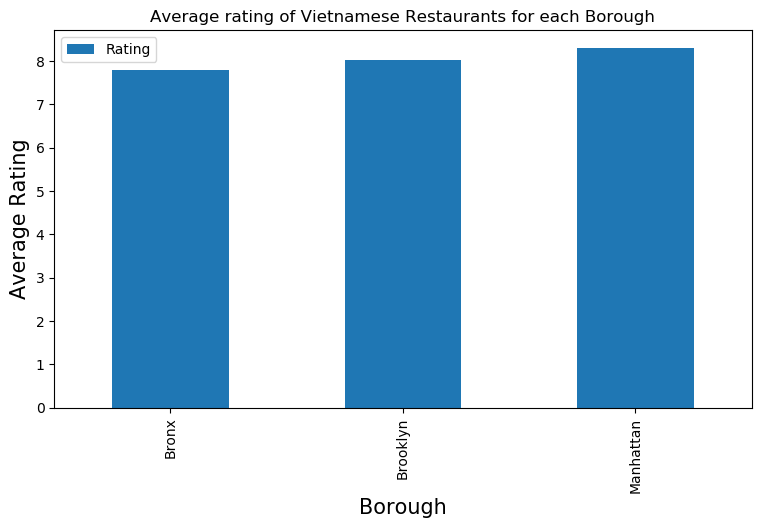

In [57]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Vietnamese Restaurants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
vietnam_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Cconsider all the neighborhoods with average rating greater or equal 7.0 to visualize on map

In [58]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=7.0]

In [59]:
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Bath Beach,7.6
1,Bay Ridge,7.3
3,Boerum Hill,8.9
4,Brooklyn Heights,7.7
5,Clinton Hill,8.6
6,Downtown,8.7
7,Dyker Heights,7.3
8,East Williamsburg,9.0
9,Fordham,7.8
10,Fort Greene,8.6


Join this dataset to original new york data to get lonitude and latitude

In [60]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [61]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [62]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Bath Beach,40.599519,-73.998752,7.6
1,Brooklyn,Bay Ridge,40.625801,-74.030621,7.3
2,Brooklyn,Boerum Hill,40.685683,-73.983748,8.9
3,Brooklyn,Brooklyn Heights,40.695864,-73.993782,7.7
4,Brooklyn,Clinton Hill,40.693229,-73.967843,8.6
5,Brooklyn,Downtown,40.690844,-73.983463,8.7
6,Brooklyn,Dyker Heights,40.619219,-74.019314,7.3
7,Brooklyn,East Williamsburg,40.708492,-73.938858,9.0
8,Bronx,Fordham,40.860997,-73.896427,7.8
9,Brooklyn,Fort Greene,40.688527,-73.972906,8.6


Show on map

In [63]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [64]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [65]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [66]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Visualize Boroughs based on average Rating

In [84]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = 'https://github.com/thientvse/Coursera_Capstone/blob/master/Borough%20Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

JSONDecodeError: Expecting value: line 7 column 1 (char 6)